# Avance 3. Baseline
# Clasificación de Texto para Requerimientos Aeroespaciales

<table>
    <tr>
        <th>
            Nombre
        </th>
        <th>
            Matrícula
        </th>
    </tr>
    <tr>
        <td>
            Julio César Lynn Jiménez
        </td>
        <td>
            A01793660
        </td>
    </tr>
</table>	

	


# Prerequisites

In [1]:
import os
os.environ['CUDA_LAUNCH_BLOCKING'] = "1"
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

In [2]:
import torch
import torch.nn as nn
from torch.utils.data import DataLoader

import numpy as np

In [3]:
if torch.cuda.is_available():
    device = torch.device('cuda')
else:
    device = torch.device('cpu')
print(device)

cuda


# Load Excel File

In [4]:
import pandas as pd
master_df = pd.read_excel('1_master_synth.xlsx')
master_df.head()

,Type,Identity,Text,A2-Unambiguous,A4-Tolerances,A5-Sources specified,E1
0,ast_adc,HLRS_1747,Massive Data Broadcast shall immediately send ...,1,na,1,1
1,ast_adc,HLRS_6673,Massive Data Broadcast shall place a copied Re...,1,na,1,1
2,ast_adc,HLRS_2470,Massive Data Broadcast shall place a copied Ma...,1,na,1,1
3,ast_adc,HLRS_2467,Massive Data Broadcast shall send the current ...,1,na,na,1
4,ast_adc,HLRS_2468,Massive Data Broadcast shall send the current ...,1,na,na,1


In [5]:
model_df = master_df[['E1','Text']].copy()
model_df.head()

,E1,Text
0,1,Massive Data Broadcast shall immediately send ...
1,1,Massive Data Broadcast shall place a copied Re...
2,1,Massive Data Broadcast shall place a copied Ma...
3,1,Massive Data Broadcast shall send the current ...
4,1,Massive Data Broadcast shall send the current ...


In [6]:
model_df_label1 = model_df.query('E1 == 1')
len(model_df_label1)

2408

In [7]:
model_df_label0 = model_df.query('E1 == 0')
len(model_df_label0)

1472

In [8]:
model_df = pd.concat([model_df_label1[:1500],model_df_label0])

# Data process and tokenizer

In [9]:
from sklearn.model_selection  import train_test_split
train_df, test_df = train_test_split(model_df, test_size=0.1, shuffle=True)

train_iter = iter(list(train_df.itertuples(index=False, name=None)))
test_iter = iter(list(test_df.itertuples(index=False, name=None)))

In [10]:
from torchtext.data.utils import get_tokenizer
from torchtext.vocab import build_vocab_from_iterator

tokenizer = get_tokenizer("basic_english")

def yield_tokens(data_iter):
    for _, text in data_iter:
        yield tokenizer(text)

vocab = build_vocab_from_iterator(yield_tokens(train_iter), specials=["<unk>"])
vocab.set_default_index(vocab["<unk>"])

# Dataset iterator

In [11]:
train_iter = iter(list(train_df.itertuples(index=False, name=None)))
test_iter = iter(list(test_df.itertuples(index=False, name=None)))

In [12]:
next(train_iter)

(0, 'No books survived the fire, did they?')

In [13]:
text_pipeline = lambda x: vocab(tokenizer(x))
label_pipeline = lambda x: int(x)

In [14]:
from torch.utils.data import DataLoader

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.long)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list.to(device), text_list.to(device), offsets.to(device)

In [15]:
train_iter = iter(list(train_df.itertuples(index=False, name=None)))
single = next(train_iter)

collate_batch([single])

(tensor([0], device='cuda:0'),
 tensor([ 120, 1169, 2602,    1, 2262,    7,   67,  341,  156], device='cuda:0'),
 tensor([0], device='cuda:0'))

# Define the model

In [16]:
from torch import nn

class TextClassificationModel(nn.Module):
    def __init__(self, vocab_size, embed_dim, num_class):
        super(TextClassificationModel, self).__init__()
        self.embedding = nn.EmbeddingBag(vocab_size, embed_dim, sparse=False)
        self.fc = nn.Linear(embed_dim, num_class)
        self.init_weights()

    def init_weights(self):
        initrange = 0.5
        self.embedding.weight.data.uniform_(-initrange, initrange)
        self.fc.weight.data.uniform_(-initrange, initrange)
        self.fc.bias.data.zero_()

    def forward(self, text, offsets):
        embedded = self.embedding(text, offsets)
        return self.fc(embedded)

In [17]:
num_class = len(set([label for (label, text) in train_iter]))
num_class

2

In [18]:
train_iter = iter(list(train_df.itertuples(index=False, name=None)))
num_class = len(set([label for (label, text) in train_iter]))
vocab_size = len(vocab)
emsize = 300
model = TextClassificationModel(vocab_size, emsize, num_class)

In [19]:
model

TextClassificationModel(
  (embedding): EmbeddingBag(4494, 300, mode='mean')
  (fc): Linear(in_features=300, out_features=2, bias=True)
)

In [20]:
from datetime import datetime
datetime.now().isoformat()

'2024-04-10T15:02:04.167664'

# Train and eval functions

In [21]:
import time

def train(model, dataloader, epoch):
    
    model.train()
    total_acc, total_count = 0, 0
    log_interval = 5
    start_time = time.time()
    total_loss = 0


    for idx, (label, text, offsets) in enumerate(dataloader):           
        optimizer.zero_grad()
        
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), 0.1)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        total_loss += loss.item()
        
        if idx % log_interval == 0 and idx > 0:
            elapsed = time.time() - start_time
            print(
                "| epoch {:3d} | {:5d}/{:5d} batches "
                "| accuracy {:8.3f} | {}".format(
                    epoch, idx, len(dataloader), total_acc / total_count, datetime.now().isoformat()
                )
            )
            start_time = time.time()
        
     
        
    return total_acc / total_count, total_loss / total_count
        

def evaluate(model, dataloader):
    model.eval()
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)

    return total_acc / total_count, loss.item() / total_count

# Split the dataset and run the model

In [22]:
from torch.utils.data.dataset import random_split
from torchtext.data.functional import to_map_style_dataset

BATCH_SIZE = 64  # batch size for training

train_iter = iter(list(train_df.itertuples(index=False, name=None)))
train_dataset = to_map_style_dataset(train_iter)
test_dataset = to_map_style_dataset(test_iter)
num_train = int(len(train_dataset) * 0.9)
split_train_, split_valid_ = random_split(
    train_dataset, [num_train, len(train_dataset) - num_train]
)

train_dataloader = DataLoader(
    split_train_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
valid_dataloader = DataLoader(
    split_valid_, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)
test_dataloader = DataLoader(
    test_dataset, batch_size=BATCH_SIZE, shuffle=True, collate_fn=collate_batch
)

In [23]:
from datetime import date

today = date.today().isoformat()
today

'2024-04-10'

In [58]:
# Hyperparameters
EPOCHS = 10  # epoch
LR = 5  # learning rate
    
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=LR)
scheduler = torch.optim.lr_scheduler.StepLR(optimizer, 1.0, gamma=0.1)
    
def train_with_hist(model, checkpoint_path = './models/simple_embeddings_baseline'):
    model = model.to(device)
    
    total_accu = None

    loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid = [], [], [], []
    for epoch in range(1, EPOCHS + 1):
        epoch_start_time = time.time()
        accu_train, loss_train = train(model, train_dataloader, epoch)
        accu_val, loss_val = evaluate(model, valid_dataloader)
        if total_accu is not None and total_accu > accu_val:
            scheduler.step()
            print("Learning rate took a step by the scheduler {:8.3f} > {:8.3f}".format(total_accu, accu_val))
        else:
            total_accu = accu_val
        print("-" * 59)
        print(
            "| end of epoch {:3d} | time: {:5.2f}s | "
            "valid accuracy {:8.3f} ".format(
                epoch, time.time() - epoch_start_time, accu_val
            )
        )
        print("-" * 59)

        loss_hist_train.append(loss_train)
        loss_hist_valid.append(loss_val)
        accuracy_hist_train.append(accu_train)
        accuracy_hist_valid.append(accu_val)
        
    torch.save(model, f'{checkpoint_path}/{today}_simple_embeddings_baseline.pt')
    return loss_hist_train, loss_hist_valid, accuracy_hist_train, accuracy_hist_valid

In [59]:
hist = train_with_hist(model, './models/simple_embeddings_baseline')

| epoch   1 |     5/   38 batches | accuracy    0.521 | 2024-04-10T14:57:10.554375
| epoch   1 |    10/   38 batches | accuracy    0.666 | 2024-04-10T14:57:10.562553
| epoch   1 |    15/   38 batches | accuracy    0.667 | 2024-04-10T14:57:10.570418
| epoch   1 |    20/   38 batches | accuracy    0.706 | 2024-04-10T14:57:10.578406
| epoch   1 |    25/   38 batches | accuracy    0.739 | 2024-04-10T14:57:10.586354
| epoch   1 |    30/   38 batches | accuracy    0.735 | 2024-04-10T14:57:10.594306
| epoch   1 |    35/   38 batches | accuracy    0.731 | 2024-04-10T14:57:10.602358
-----------------------------------------------------------
| end of epoch   1 | time:  0.07s | valid accuracy    0.862 
-----------------------------------------------------------
| epoch   2 |     5/   38 batches | accuracy    0.906 | 2024-04-10T14:57:10.618587
| epoch   2 |    10/   38 batches | accuracy    0.929 | 2024-04-10T14:57:10.626813
| epoch   2 |    15/   38 batches | accuracy    0.918 | 2024-04-10T14:57

In [60]:
import numpy as np
import matplotlib.pyplot as plt
def plot_learning_curves(hist):
    x_arr = np.arange(len(hist[0])) + 1
    fig = plt.figure(figsize=(12, 4))
    ax = fig.add_subplot(1, 2, 1)
    ax.plot(x_arr, hist[0], '-o', label='Train loss')
    ax.plot(x_arr, hist[1], '--<', label='Validation loss')
    ax.legend(fontsize=15)
    ax = fig.add_subplot(1, 2, 2)
    ax.plot(x_arr, hist[2], '-o', label='Train acc.')
    ax.plot(x_arr, hist[3], '--<', label='Validation acc.')
    ax.legend(fontsize=15)
    ax.set_xlabel('Epoch', size=15)
    ax.set_ylabel('Accuracy', size=15)
    plt.show()

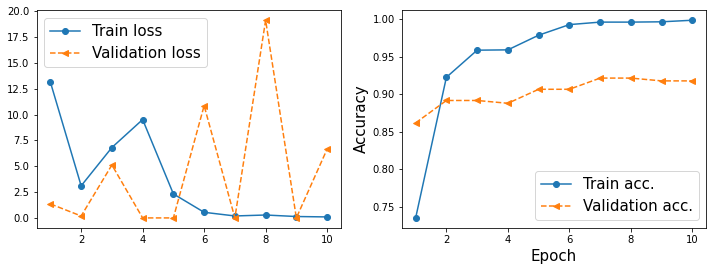

In [61]:
plot_learning_curves(hist)

### Evaluate the model with test dataset

Checking the results of the test dataset…



In [62]:
print("Checking the results of test dataset.")
accu_test, _ = evaluate(model, test_dataloader)
print("test accuracy {:8.3f}".format(accu_test))

Checking the results of test dataset.
test accuracy    0.956


In [38]:
# create confusion matrix
from sklearn.metrics import classification_report, confusion_matrix
import seaborn as sns

def plot_confusion_matrix(model, dataloader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    
    model.eval()
    y_test = np.asarray([])
    y_predict = np.asarray([])

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(dataloader):
            (label, text, offsets) = label.to(device), text.to(device), offsets.to(device)
            
            predicted_label = model(text, offsets)
                  
            y_test = np.concatenate((y_test, np.asarray(label.to(device='cpu', dtype=int))), axis=None)
            y_predict = np.concatenate((y_predict, np.asarray((predicted_label.argmax(1).to(device='cpu', dtype=int)))), axis=None)

    cm = confusion_matrix(y_test, y_predict)
    sns.heatmap(cm, annot=True, fmt = "d")
    print(classification_report(y_test, y_predict))

              precision    recall  f1-score   support

         0.0       0.94      0.97      0.95       141
         1.0       0.97      0.94      0.96       157

    accuracy                           0.96       298
   macro avg       0.96      0.96      0.96       298
weighted avg       0.96      0.96      0.96       298



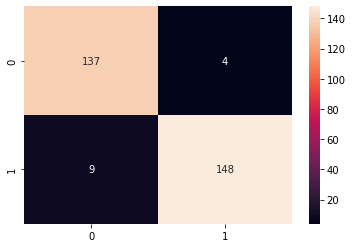

In [64]:
plot_confusion_matrix(model, test_dataloader)

In [65]:
def predict(text):
    with torch.no_grad():
        model_device = model.to(device)
        text = torch.tensor(text_pipeline(text)).to(device)
        output = model_device(text, torch.tensor([0]).to(device))
        return output.argmax(1).item()


ex_text_str = "The software shall use the front serial port to transmit and receive the PDIFs to and from an external source."

print("This is a %s" % predict(ex_text_str))

This is a 0


In [66]:
test_req2 = "The software shall enforce the Principle of Least Privilege."

In [67]:
print("This is a %s" % predict(test_req2))

This is a 1


In [68]:
test_req3 = "The software shall support the upload/download of configurable options as defined in document 702-074876."

In [69]:
print("This is a %s" % predict(test_req3))

This is a 1


# Hyperparameter tunning with Ray Tune

In [24]:
import time
from datetime import datetime, date

import ray
import ray.train.torch

from ray import train, tune
from ray.train import RunConfig, ScalingConfig, Checkpoint
from ray.train.torch import TorchTrainer

from ray.tune.schedulers import ASHAScheduler

In [25]:
!nvidia-smi

Wed Apr 10 15:02:34 2024       
+---------------------------------------------------------------------------------------+
| NVIDIA-SMI 535.161.07             Driver Version: 535.161.07   CUDA Version: 12.2     |
|-----------------------------------------+----------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |         Memory-Usage | GPU-Util  Compute M. |
|                                         |                      |               MIG M. |
|=========================================+======================+======================|
|   0  NVIDIA GeForce RTX 4090        Off | 00000000:01:00.0 Off |                  Off |
|  0%   50C    P8              19W / 500W |    791MiB / 24564MiB |      0%      Default |
|                                         |                      |                  N/A |
+-----------------------------------------+----------------------+--

In [26]:
ray.get_gpu_ids()

2024-04-10 15:02:36,932	INFO worker.py:1724 -- Started a local Ray instance.


[]

In [73]:
torch.cuda.is_available()

True

In [74]:
ray.train.torch.get_device()

device(type='cuda', index=0)

In [78]:
device

'cuda:0'

In [79]:
if torch.cuda.is_available():
        device = "cuda:0"
        if torch.cuda.device_count() > 1:
            model = nn.DataParallel(model)

In [80]:
torch.cuda.device_count()

1

In [27]:
from torch.utils.data import DataLoader

def collate_batch(batch):
    label_list, text_list, offsets = [], [], [0]
    for _label, _text in batch:
        label_list.append(label_pipeline(_label))
        processed_text = torch.tensor(text_pipeline(_text), dtype=torch.long)
        text_list.append(processed_text)
        offsets.append(processed_text.size(0))
    label_list = torch.tensor(label_list, dtype=torch.int64)
    offsets = torch.tensor(offsets[:-1]).cumsum(dim=0)
    text_list = torch.cat(text_list)
    return label_list, text_list, offsets

In [28]:
def train_func(model, optimizer, train_loader, max_norm):  
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.train()
    
    total_acc, total_count = 0, 0
    log_interval = 5
    start_time = time.time()
    total_loss = 0

    for idx, (label, text, offsets) in enumerate(train_loader):           
        label, text, offsets = label.to(device), text.to(device), offsets.to(device)
        
        optimizer.zero_grad()
        
        predicted_label = model(text, offsets)
        loss = criterion(predicted_label, label)
        
        loss.backward()
        torch.nn.utils.clip_grad_norm_(model.parameters(), max_norm)
        optimizer.step()
        total_acc += (predicted_label.argmax(1) == label).sum().item()
        total_count += label.size(0)
        total_loss += loss.item()
         
    return total_acc / total_count, total_loss / total_count
        

def eval_func(model, data_loader):
    device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
    model.eval()
    
    total_acc, total_count = 0, 0

    with torch.no_grad():
        for idx, (label, text, offsets) in enumerate(data_loader):
            label, text, offsets = label.to(device), text.to(device), offsets.to(device)
            
            predicted_label = model(text, offsets)
            loss = criterion(predicted_label, label)
            total_acc += (predicted_label.argmax(1) == label).sum().item()
            total_count += label.size(0)

    return total_acc / total_count, loss.item() / total_count

In [29]:
import os
import tempfile

today = date.today().isoformat()
checkpoint_path = "./models/simple_embeddings_baseline"
model_name = "simple_embeddings_baseline"
num_class = 2
vocab_size = len(vocab)


def train_search(config):
    device = "cuda:0" if torch.cuda.is_available() else "cpu"
    print(device)
    print(config)
    # config_params = config["params"]
    config_params = config
    # print(config_params)
    
    model = TextClassificationModel(vocab_size, config_params["embed_dim"], num_class)
    model = model.to(device)
    
    

    train_dataloader = DataLoader(
        split_train_, batch_size=config_params["batch_size"], shuffle=True, collate_fn=collate_batch
    )
    valid_dataloader = DataLoader(
        split_valid_, batch_size=config_params["batch_size"], shuffle=True, collate_fn=collate_batch
    )
    test_dataloader = DataLoader(
        test_dataset, batch_size=config_params["batch_size"], shuffle=True, collate_fn=collate_batch
    )
    
    # optimizer = torch.optim.Adam(model.parameters(), lr=config_params["lr"])
    optimizer = torch.optim.SGD(model.parameters(), lr=config_params["lr"], momentum=config_params["momentum"])
    scheduler = torch.optim.lr_scheduler.StepLR(optimizer, step_size=config_params["step_size"], gamma=config_params["lr_gamma"])
    criterion = torch.nn.CrossEntropyLoss()
    
    for epoch in range(1, config_params["epochs"] + 1):
        epoch_start_time = time.time()
        accu_train, loss_train = train_func(model, optimizer, train_dataloader, config_params["max_norm"])
        accu_val, loss_val = eval_func(model, valid_dataloader)
        
        # Always let the scheduler take a step because it will be optimized by Hyperopt
        scheduler.step()
            
        with tempfile.TemporaryDirectory() as temp_checkpoint_dir:
            checkpoint = None
            if epoch % 5 == 0:
                # This saves the model to the trial directory
                torch.save(
                    model.state_dict(),
                    os.path.join(temp_checkpoint_dir, "model.pth")
                )
                checkpoint = Checkpoint.from_directory(temp_checkpoint_dir)

            # Send the current training result back to Ray Tune
            train.report({
                "loss_train": loss_train,
                "loss_val": loss_val,
                "accuracy_train": accu_train,
                "accuracy_val": accu_val,
            }, checkpoint=checkpoint)

In [84]:
# ray.remote(num_cpus=32, num_gpus=1)

In [85]:
import numpy as np
from hyperopt import hp
from ray.tune.search.hyperopt import HyperOptSearch

exp_name = "simple_embeddings_baseline"

space = {
    "lr": hp.loguniform("lr", -4, -1),
    "momentum": hp.uniform("momentum", 0.1, 0.9),
    "embed_dim": hp.choice("embed_dim", [100, 200, 300, 400, 500]),
    "epochs": hp.choice("epochs", [10, 20, 30]),
    "batch_size": hp.choice("batch_size", [32, 64, 128]),
    "step_size": hp.randint("step_size", 1, 10),
    "lr_gamma": hp.uniform("lr_gamma", 0.1, 0.9),
    "max_norm": hp.uniform("max_norm", 0.1, 0.9),
}

hyperopt_search = HyperOptSearch(space, metric="accuracy_val", mode="max")

# Uncomment this to enable distributed execution
# `ray.init(address="auto")`

tuner = tune.Tuner(
    tune.with_resources(train_search, resources={"cpu":12, "gpu":1}),
    tune_config=tune.TuneConfig(
        num_samples=50,
        scheduler=ASHAScheduler(metric="accuracy_val", mode="max"), # Early stopping
        search_alg=hyperopt_search, # Hyperopt library for Hyper-parameter Optimization
    ),
    run_config=train.RunConfig(
        name=exp_name,
        checkpoint_config=train.CheckpointConfig(
            checkpoint_score_attribute="accuracy_val",
            num_to_keep=2,
            # checkpoint_at_end=True
        ),
    ),
)
results = tuner.fit()

(train_search pid=15488) cuda:0
(train_search pid=15488) {'batch_size': 32, 'embed_dim': 400, 'epochs': 20, 'lr': 0.03867501386441663, 'lr_gamma': 0.5320806213172047, 'max_norm': 0.42812509256269804, 'momentum': 0.8584655629326633, 'step_size': 5}


(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_7ea361b4_1_batch_size=32,embed_dim=400,epochs=20,lr=0.0387,lr_gamma=0.5321,max_norm=0.4281,momentum=0.8585,step_size=_2024-04-10_14-57-55/checkpoint_000000)
(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_7ea361b4_1_batch_size=32,embed_dim=400,epochs=20,lr=0.0387,lr_gamma=0.5321,max_norm=0.4281,momentum=0.8585,step_size=_2024-04-10_14-57-55/checkpoint_000001)
(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_7ea361b4_1_batch_size=32,embed_dim=400,epochs=20,lr=0.0387,lr_gamma=0.5321,max_norm=0.4281,momentum=0.8585,step_size=_2024-04-10_14-57-55/checkpoint_000002)
(train_search pid=15488) Checkpoint successfully created at: 

(train_search pid=15488) cuda:0
(train_search pid=15488) {'batch_size': 32, 'embed_dim': 100, 'epochs': 20, 'lr': 0.23721039875685415, 'lr_gamma': 0.5995369915579233, 'max_norm': 0.6750928393520892, 'momentum': 0.4585703763112676, 'step_size': 5}


(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_362b149a_2_batch_size=32,embed_dim=100,epochs=20,lr=0.2372,lr_gamma=0.5995,max_norm=0.6751,momentum=0.4586,step_size=_2024-04-10_14-57-57/checkpoint_000000)
(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_362b149a_2_batch_size=32,embed_dim=100,epochs=20,lr=0.2372,lr_gamma=0.5995,max_norm=0.6751,momentum=0.4586,step_size=_2024-04-10_14-57-57/checkpoint_000001)
(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_362b149a_2_batch_size=32,embed_dim=100,epochs=20,lr=0.2372,lr_gamma=0.5995,max_norm=0.6751,momentum=0.4586,step_size=_2024-04-10_14-57-57/checkpoint_000002)
(train_search pid=15488) Checkpoint successfully created at: 

(train_search pid=15488) cuda:0
(train_search pid=15488) {'batch_size': 64, 'embed_dim': 100, 'epochs': 30, 'lr': 0.023664591473888028, 'lr_gamma': 0.7893055057907131, 'max_norm': 0.7128080652252268, 'momentum': 0.5848201214663963, 'step_size': 4}
(train_search pid=15488) cuda:0
(train_search pid=15488) {'batch_size': 64, 'embed_dim': 100, 'epochs': 20, 'lr': 0.34986729830849117, 'lr_gamma': 0.1275599179605803, 'max_norm': 0.673459452203113, 'momentum': 0.2649648652260478, 'step_size': 9}
(train_search pid=15488) cuda:0
(train_search pid=15488) {'batch_size': 128, 'embed_dim': 400, 'epochs': 20, 'lr': 0.1034728076209637, 'lr_gamma': 0.2206314612656442, 'max_norm': 0.2598830249367108, 'momentum': 0.7622236927348424, 'step_size': 9}
(train_search pid=15488) cuda:0
(train_search pid=15488) {'batch_size': 128, 'embed_dim': 100, 'epochs': 10, 'lr': 0.06733108498615062, 'lr_gamma': 0.8183980315570218, 'max_norm': 0.7479241779454523, 'momentum': 0.36312244419356143, 'step_size': 3}
(train_sea

(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_a6e955bf_10_batch_size=32,embed_dim=400,epochs=30,lr=0.0512,lr_gamma=0.4694,max_norm=0.5197,momentum=0.8375,step_size_2024-04-10_14-58-01/checkpoint_000000)
(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_a6e955bf_10_batch_size=32,embed_dim=400,epochs=30,lr=0.0512,lr_gamma=0.4694,max_norm=0.5197,momentum=0.8375,step_size_2024-04-10_14-58-01/checkpoint_000001)
(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_a6e955bf_10_batch_size=32,embed_dim=400,epochs=30,lr=0.0512,lr_gamma=0.4694,max_norm=0.5197,momentum=0.8375,step_size_2024-04-10_14-58-01/checkpoint_000002)


(train_search pid=15488) cuda:0
(train_search pid=15488) {'batch_size': 64, 'embed_dim': 400, 'epochs': 10, 'lr': 0.21715015365461954, 'lr_gamma': 0.7917406879260217, 'max_norm': 0.4344174552597506, 'momentum': 0.8109459935396153, 'step_size': 7}


(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_7baf5e39_11_batch_size=64,embed_dim=400,epochs=10,lr=0.2172,lr_gamma=0.7917,max_norm=0.4344,momentum=0.8109,step_size_2024-04-10_14-58-01/checkpoint_000000)
(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_7baf5e39_11_batch_size=64,embed_dim=400,epochs=10,lr=0.2172,lr_gamma=0.7917,max_norm=0.4344,momentum=0.8109,step_size_2024-04-10_14-58-01/checkpoint_000001)


(train_search pid=15488) cuda:0
(train_search pid=15488) {'batch_size': 32, 'embed_dim': 200, 'epochs': 30, 'lr': 0.17862786357732172, 'lr_gamma': 0.6530631536296678, 'max_norm': 0.6356330002142838, 'momentum': 0.7186439222998152, 'step_size': 2}
(train_search pid=15488) cuda:0
(train_search pid=15488) {'batch_size': 32, 'embed_dim': 500, 'epochs': 30, 'lr': 0.13274427327444946, 'lr_gamma': 0.27044560454827304, 'max_norm': 0.3285928252677136, 'momentum': 0.8501199889555368, 'step_size': 6}


(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_15f4227f_13_batch_size=32,embed_dim=500,epochs=30,lr=0.1327,lr_gamma=0.2704,max_norm=0.3286,momentum=0.8501,step_size_2024-04-10_14-58-03/checkpoint_000000)
(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_15f4227f_13_batch_size=32,embed_dim=500,epochs=30,lr=0.1327,lr_gamma=0.2704,max_norm=0.3286,momentum=0.8501,step_size_2024-04-10_14-58-03/checkpoint_000001)
(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_15f4227f_13_batch_size=32,embed_dim=500,epochs=30,lr=0.1327,lr_gamma=0.2704,max_norm=0.3286,momentum=0.8501,step_size_2024-04-10_14-58-03/checkpoint_000002)
(train_search pid=15488) Checkpoint successfully created at: 

(train_search pid=15488) cuda:0
(train_search pid=15488) {'batch_size': 64, 'embed_dim': 200, 'epochs': 10, 'lr': 0.05273677079150175, 'lr_gamma': 0.16278298088862186, 'max_norm': 0.5004134314656674, 'momentum': 0.762474922599858, 'step_size': 1}
(train_search pid=15488) cuda:0
(train_search pid=15488) {'batch_size': 32, 'embed_dim': 100, 'epochs': 10, 'lr': 0.06051758725364498, 'lr_gamma': 0.5739179114659945, 'max_norm': 0.2506587352424646, 'momentum': 0.7927251912769764, 'step_size': 3}
(train_search pid=15488) cuda:0
(train_search pid=15488) {'batch_size': 128, 'embed_dim': 300, 'epochs': 10, 'lr': 0.02090069874777538, 'lr_gamma': 0.7614477707424568, 'max_norm': 0.5922039305227781, 'momentum': 0.21173184833703715, 'step_size': 7}
(train_search pid=15488) cuda:0
(train_search pid=15488) {'batch_size': 128, 'embed_dim': 300, 'epochs': 10, 'lr': 0.07127794270815402, 'lr_gamma': 0.4933268156794014, 'max_norm': 0.4157417733630797, 'momentum': 0.616505537196441, 'step_size': 5}
(train_sea

(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_e0e4d254_25_batch_size=32,embed_dim=100,epochs=30,lr=0.2478,lr_gamma=0.2420,max_norm=0.5764,momentum=0.8895,step_size_2024-04-10_14-58-07/checkpoint_000000)
(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_e0e4d254_25_batch_size=32,embed_dim=100,epochs=30,lr=0.2478,lr_gamma=0.2420,max_norm=0.5764,momentum=0.8895,step_size_2024-04-10_14-58-07/checkpoint_000001)
(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_e0e4d254_25_batch_size=32,embed_dim=100,epochs=30,lr=0.2478,lr_gamma=0.2420,max_norm=0.5764,momentum=0.8895,step_size_2024-04-10_14-58-07/checkpoint_000002)
(train_search pid=15488) Checkpoint successfully created at: 

(train_search pid=15488) cuda:0
(train_search pid=15488) {'batch_size': 32, 'embed_dim': 500, 'epochs': 20, 'lr': 0.10807529498463217, 'lr_gamma': 0.4313145951664672, 'max_norm': 0.33355017077188387, 'momentum': 0.4323762586233974, 'step_size': 8}
(train_search pid=15488) cuda:0
(train_search pid=15488) {'batch_size': 32, 'embed_dim': 200, 'epochs': 30, 'lr': 0.30113452000045304, 'lr_gamma': 0.2267483302030566, 'max_norm': 0.5793604263922993, 'momentum': 0.8922985073872801, 'step_size': 4}


(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_f57d96f7_27_batch_size=32,embed_dim=200,epochs=30,lr=0.3011,lr_gamma=0.2267,max_norm=0.5794,momentum=0.8923,step_size_2024-04-10_14-58-10/checkpoint_000000)
(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_f57d96f7_27_batch_size=32,embed_dim=200,epochs=30,lr=0.3011,lr_gamma=0.2267,max_norm=0.5794,momentum=0.8923,step_size_2024-04-10_14-58-10/checkpoint_000001)
(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_f57d96f7_27_batch_size=32,embed_dim=200,epochs=30,lr=0.3011,lr_gamma=0.2267,max_norm=0.5794,momentum=0.8923,step_size_2024-04-10_14-58-10/checkpoint_000002)


(train_search pid=15488) cuda:0
(train_search pid=15488) {'batch_size': 32, 'embed_dim': 500, 'epochs': 30, 'lr': 0.19160283317175064, 'lr_gamma': 0.10709667500447448, 'max_norm': 0.2028041005756147, 'momentum': 0.8929662373845024, 'step_size': 6}


(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_f8d74936_28_batch_size=32,embed_dim=500,epochs=30,lr=0.1916,lr_gamma=0.1071,max_norm=0.2028,momentum=0.8930,step_size_2024-04-10_14-58-10/checkpoint_000000)
(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_f8d74936_28_batch_size=32,embed_dim=500,epochs=30,lr=0.1916,lr_gamma=0.1071,max_norm=0.2028,momentum=0.8930,step_size_2024-04-10_14-58-10/checkpoint_000001)
(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_f8d74936_28_batch_size=32,embed_dim=500,epochs=30,lr=0.1916,lr_gamma=0.1071,max_norm=0.2028,momentum=0.8930,step_size_2024-04-10_14-58-10/checkpoint_000002)
(train_search pid=15488) Checkpoint successfully created at: 

(train_search pid=15488) cuda:0
(train_search pid=15488) {'batch_size': 32, 'embed_dim': 100, 'epochs': 30, 'lr': 0.14995016157784785, 'lr_gamma': 0.2604844958353343, 'max_norm': 0.5388914152483202, 'momentum': 0.883947189563366, 'step_size': 5}
(train_search pid=15488) cuda:0
(train_search pid=15488) {'batch_size': 32, 'embed_dim': 300, 'epochs': 30, 'lr': 0.20194942180930758, 'lr_gamma': 0.108288520587935, 'max_norm': 0.23317759204945523, 'momentum': 0.8920800848677178, 'step_size': 5}


(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_ca66293a_30_batch_size=32,embed_dim=300,epochs=30,lr=0.2019,lr_gamma=0.1083,max_norm=0.2332,momentum=0.8921,step_size_2024-04-10_14-58-14/checkpoint_000000)
(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_ca66293a_30_batch_size=32,embed_dim=300,epochs=30,lr=0.2019,lr_gamma=0.1083,max_norm=0.2332,momentum=0.8921,step_size_2024-04-10_14-58-14/checkpoint_000001)
(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_ca66293a_30_batch_size=32,embed_dim=300,epochs=30,lr=0.2019,lr_gamma=0.1083,max_norm=0.2332,momentum=0.8921,step_size_2024-04-10_14-58-14/checkpoint_000002)


(train_search pid=15488) cuda:0
(train_search pid=15488) {'batch_size': 32, 'embed_dim': 100, 'epochs': 30, 'lr': 0.2354280544252845, 'lr_gamma': 0.17486217475514798, 'max_norm': 0.18206339056276938, 'momentum': 0.7218242418424896, 'step_size': 5}
(train_search pid=15488) cuda:0
(train_search pid=15488) {'batch_size': 32, 'embed_dim': 200, 'epochs': 30, 'lr': 0.28970482328962227, 'lr_gamma': 0.33537762970196694, 'max_norm': 0.45863922057436646, 'momentum': 0.7036561350370271, 'step_size': 4}
(train_search pid=15488) cuda:0
(train_search pid=15488) {'batch_size': 64, 'embed_dim': 100, 'epochs': 30, 'lr': 0.3517425308970027, 'lr_gamma': 0.1734631725467593, 'max_norm': 0.36825966380254693, 'momentum': 0.5480250727481859, 'step_size': 8}
(train_search pid=15488) cuda:0
(train_search pid=15488) {'batch_size': 32, 'embed_dim': 500, 'epochs': 30, 'lr': 0.09083647469780742, 'lr_gamma': 0.10228879171659788, 'max_norm': 0.6433833666629314, 'momentum': 0.6689452369399506, 'step_size': 7}
(train_s

(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_7e1836d6_46_batch_size=64,embed_dim=500,epochs=30,lr=0.3674,lr_gamma=0.2043,max_norm=0.7864,momentum=0.8678,step_size_2024-04-10_14-58-18/checkpoint_000000)
(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_7e1836d6_46_batch_size=64,embed_dim=500,epochs=30,lr=0.3674,lr_gamma=0.2043,max_norm=0.7864,momentum=0.8678,step_size_2024-04-10_14-58-18/checkpoint_000001)
(train_search pid=15488) Checkpoint successfully created at: Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_7e1836d6_46_batch_size=64,embed_dim=500,epochs=30,lr=0.3674,lr_gamma=0.2043,max_norm=0.7864,momentum=0.8678,step_size_2024-04-10_14-58-18/checkpoint_000002)


(train_search pid=15488) cuda:0
(train_search pid=15488) {'batch_size': 32, 'embed_dim': 200, 'epochs': 10, 'lr': 0.20238101535792022, 'lr_gamma': 0.41406255256245905, 'max_norm': 0.4855396159461203, 'momentum': 0.18964225348158764, 'step_size': 5}
(train_search pid=15488) cuda:0
(train_search pid=15488) {'batch_size': 128, 'embed_dim': 300, 'epochs': 30, 'lr': 0.08840297552836114, 'lr_gamma': 0.8805071906993409, 'max_norm': 0.8446771547431768, 'momentum': 0.7767675976967543, 'step_size': 1}
(train_search pid=15488) cuda:0
(train_search pid=15488) {'batch_size': 32, 'embed_dim': 400, 'epochs': 10, 'lr': 0.07510646816575559, 'lr_gamma': 0.29747194538261457, 'max_norm': 0.14590953144011343, 'momentum': 0.33901918184899016, 'step_size': 6}


2024-04-10 14:58:19,590	INFO tune.py:1042 -- Total run time: 24.68 seconds (24.46 seconds for the tuning loop).


(train_search pid=15488) cuda:0
(train_search pid=15488) {'batch_size': 64, 'embed_dim': 100, 'epochs': 30, 'lr': 0.06279553446661065, 'lr_gamma': 0.4904901679784516, 'max_norm': 0.4427622177086994, 'momentum': 0.7448043002709186, 'step_size': 9}


[<AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>,
 <AxesSubplot:>]

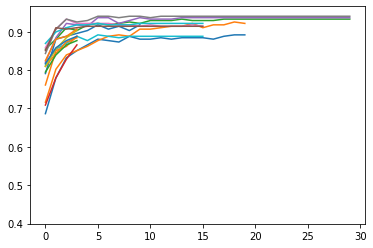

In [86]:
dfs = {result.path: result.metrics_dataframe for result in results}
[d["accuracy_val"].plot() for d in dfs.values()]

In [87]:
len(results)

50

In [88]:
best_result = results.get_best_result("accuracy_val", "max")

In [89]:
best_result.config

{'batch_size': 32,
 'embed_dim': 500,
 'epochs': 30,
 'lr': 0.19160283317175064,
 'lr_gamma': 0.10709667500447448,
 'max_norm': 0.2028041005756147,
 'momentum': 0.8929662373845024,
 'step_size': 6}

In [90]:
best_result.metrics_dataframe

,loss_train,loss_val,accuracy_train,accuracy_val,timestamp,checkpoint_dir_name,done,training_iteration,trial_id,date,...,iterations_since_restore,config/batch_size,config/embed_dim,config/epochs,config/lr,config/lr_gamma,config/max_norm,config/momentum,config/step_size,should_checkpoint
0,0.015004,0.001229,0.768080,0.843284,1712786291,None,False,1,f8d74936,2024-04-10_14-58-11,...,1,32,500,30,0.191603,0.107097,0.202804,0.892966,6,NaN
1,0.008461,0.000827,0.898171,0.906716,1712786291,None,False,2,f8d74936,2024-04-10_14-58-11,...,2,32,500,30,0.191603,0.107097,0.202804,0.892966,6,NaN
2,0.006313,0.000525,0.931837,0.932836,1712786291,None,False,3,f8d74936,2024-04-10_14-58-11,...,3,32,500,30,0.191603,0.107097,0.202804,0.892966,6,NaN
3,0.005151,0.000392,0.943475,0.925373,1712786292,None,False,4,f8d74936,2024-04-10_14-58-12,...,4,32,500,30,0.191603,0.107097,0.202804,0.892966,6,NaN
4,0.004419,0.000646,0.948878,0.929104,1712786292,checkpoint_000000,False,5,f8d74936,2024-04-10_14-58-12,...,5,32,500,30,0.191603,0.107097,0.202804,0.892966,6,True
5,0.003629,0.000254,0.963840,0.940299,1712786292,None,False,6,f8d74936,2024-04-10_14-58-12,...,6,32,500,30,0.191603,0.107097,0.202804,0.892966,6,NaN
6,0.002924,0.001043,0.972569,0.940299,1712786292,None,False,7,f8d74936,2024-04-10_14-58-12,...,7,32,500,30,0.191603,0.107097,0.202804,0.892966,6,NaN
7,0.002893,0.000150,0.972569,0.936567,1712786292,None,False,8,f8d74936,2024-04-10_14-58-12,...,8,32,500,30,0.191603,0.107097,0.202804,0.892966,6,NaN
8,0.002817,0.000508,0.975894,0.940299,1712786292,None,False,9,f8d74936,2024-04-10_14-58-12,...,9,32,500,30,0.191603,0.107097,0.202804,0.892966,6,NaN
9,0.002787,0.001481,0.972153,0.940299,1712786292,checkpoint_000001,False,10,f8d74936,2024-04-10_14-58-12,...,10,32,500,30,0.191603,0.107097,0.202804,0.892966,6,True


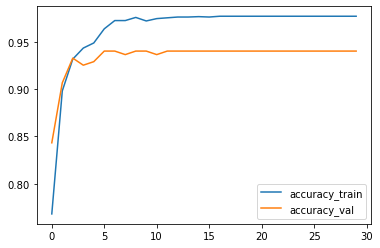

In [91]:
import matplotlib.pyplot as plt

df = best_result.metrics_dataframe

plt.plot(df['accuracy_train'], label='accuracy_train')
plt.plot(df['accuracy_val'], label='accuracy_val')

plt.legend(title='')

plt.show()

In [92]:
best_checkpoints = best_result.best_checkpoints
best_checkpoints

[(Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_f8d74936_28_batch_size=32,embed_dim=500,epochs=30,lr=0.1916,lr_gamma=0.1071,max_norm=0.2028,momentum=0.8930,step_size_2024-04-10_14-58-10/checkpoint_000004),
  {'loss_train': 0.002576788528555275,
   'loss_val': 0.000266866313654985,
   'accuracy_train': 0.9771404821280133,
   'accuracy_val': 0.9402985074626866,
   'timestamp': 1712786293,
   'checkpoint_dir_name': 'checkpoint_000004',
   'should_checkpoint': True,
   'done': False,
   'training_iteration': 25,
   'trial_id': 'f8d74936',
   'date': '2024-04-10_14-58-13',
   'time_this_iter_s': 0.09457659721374512,
   'time_total_s': 2.1354544162750244,
   'pid': 15488,
   'hostname': 'coeus',
   'node_ip': '10.1.1.204',
   'config': {'batch_size': 32,
    'embed_dim': 500,
    'epochs': 30,
    'lr': 0.19160283317175064,
    'lr_gamma': 0.10709667500447448,
    'max_norm': 0.2028041005756147,
    'momentum': 0.8929662373845024,
    'step_si

## Evaluating Your Model after Tuning

In [93]:
best_result = results.get_best_result("accuracy_val", mode="max")
best_result

Result(
  metrics={'loss_train': 0.002572564256446419, 'loss_val': 0.0004888132436951595, 'accuracy_train': 0.9771404821280133, 'accuracy_val': 0.9402985074626866},
  path='/home/it/ray_results/simple_embeddings_baseline/train_search_f8d74936_28_batch_size=32,embed_dim=500,epochs=30,lr=0.1916,lr_gamma=0.1071,max_norm=0.2028,momentum=0.8930,step_size_2024-04-10_14-58-10',
  filesystem='local',
  checkpoint=Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_f8d74936_28_batch_size=32,embed_dim=500,epochs=30,lr=0.1916,lr_gamma=0.1071,max_norm=0.2028,momentum=0.8930,step_size_2024-04-10_14-58-10/checkpoint_000005)
)

In [94]:
best_checkpoint = best_result.get_best_checkpoint("accuracy_val", mode="max")

In [95]:
best_checkpoint.path

'/home/it/ray_results/simple_embeddings_baseline/train_search_f8d74936_28_batch_size=32,embed_dim=500,epochs=30,lr=0.1916,lr_gamma=0.1071,max_norm=0.2028,momentum=0.8930,step_size_2024-04-10_14-58-10/checkpoint_000004'

In [96]:
next(x for x in best_checkpoints if x[0].path == best_checkpoint.path)

(Checkpoint(filesystem=local, path=/home/it/ray_results/simple_embeddings_baseline/train_search_f8d74936_28_batch_size=32,embed_dim=500,epochs=30,lr=0.1916,lr_gamma=0.1071,max_norm=0.2028,momentum=0.8930,step_size_2024-04-10_14-58-10/checkpoint_000004),
 {'loss_train': 0.002576788528555275,
  'loss_val': 0.000266866313654985,
  'accuracy_train': 0.9771404821280133,
  'accuracy_val': 0.9402985074626866,
  'timestamp': 1712786293,
  'checkpoint_dir_name': 'checkpoint_000004',
  'should_checkpoint': True,
  'done': False,
  'training_iteration': 25,
  'trial_id': 'f8d74936',
  'date': '2024-04-10_14-58-13',
  'time_this_iter_s': 0.09457659721374512,
  'time_total_s': 2.1354544162750244,
  'pid': 15488,
  'hostname': 'coeus',
  'node_ip': '10.1.1.204',
  'config': {'batch_size': 32,
   'embed_dim': 500,
   'epochs': 30,
   'lr': 0.19160283317175064,
   'lr_gamma': 0.10709667500447448,
   'max_norm': 0.2028041005756147,
   'momentum': 0.8929662373845024,
   'step_size': 6},
  'time_since_re

In [97]:
state_dict = torch.load(os.path.join(best_checkpoint.path, "model.pth"))

num_class = 2
vocab_size = len(vocab)
model = TextClassificationModel(vocab_size, best_result.config["embed_dim"], num_class)
model.load_state_dict(state_dict)

<All keys matched successfully>

In [98]:
model

TextClassificationModel(
  (embedding): EmbeddingBag(4524, 500, mode='mean')
  (fc): Linear(in_features=500, out_features=2, bias=True)
)

In [99]:
uq_path = today + "_" + "_".join(best_result.path.split("=")[0].split("/")[-2:])
save_path = os.path.join('./models/simple_embeddings_baseline', uq_path + "_model.pt")

In [100]:
torch.save(model, save_path)

In [113]:
device

device(type='cuda')

In [30]:
model = torch.load("./models/simple_embeddings_baseline/2024-04-10_simple_embeddings_baseline_train_search_f8d74936_28_batch_size_model.pt",
                   map_location = device)

In [31]:
model

TextClassificationModel(
  (embedding): EmbeddingBag(4524, 500, mode='mean')
  (fc): Linear(in_features=500, out_features=2, bias=True)
)

In [108]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = model.to(device, non_blocking=True)

In [32]:
test_df = pd.read_excel('TestDataset.xlsx')
test_df = test_df[['E1','Text']]
#Convert E1 column values to integers
test_df['E1'] = test_df['E1'].astype(int)
test_df.head()

,E1,Text
0,1,The FA shall interpret each ARINC 429 word as ...
1,1,The FA shall identify the validity of the data...
2,0,The FA shall identify the validity of the data...
3,0,The FA shall interpret each ARINC 429 word as ...
4,1,The FA shall interpret bits 8-1 to indicate th...


In [33]:
from torchtext.data.functional import to_map_style_dataset

test_iter = iter(list(test_df.itertuples(index=False, name=None)))
test_dataset = to_map_style_dataset(test_iter)
    
test_dataloader = DataLoader(test_dataset,
                             batch_size=64,
                             shuffle=False,
                             collate_fn=collate_batch)

              precision    recall  f1-score   support

         0.0       0.55      0.72      0.63       210
         1.0       0.60      0.41      0.49       210

    accuracy                           0.57       420
   macro avg       0.57      0.57      0.56       420
weighted avg       0.57      0.57      0.56       420



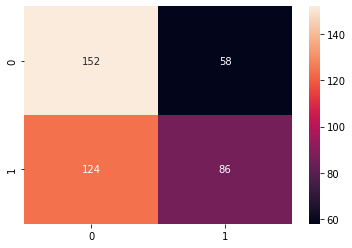

In [39]:
plot_confusion_matrix(model, test_dataloader)